<a href="https://colab.research.google.com/github/raj-vijay/mv/blob/master/08_Lab_7_Image_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BACKGROUND**

<p align = 'justify'>In lecture 7 we looked at the JPEG image compression algorithm. In this lab you will implement some aspects of this algorithm and observe the resulting compression artefacts.</p>

**Task 1**

<p align = 'justify'>Load the image file baboon.png available on Canvas and convert it into Y’CrCb colour space using the function cv2.cvtColor(). Display all three channels separately.</p>


**Task 2**

<p align = 'justify'>Downsample the Cb and the Cr channel by combining blocks of neighbouring pixels into an average value. Parameterise the block size to control the size of the Cb and the Cr channel of the resulting image.</p>


**Task 3**

<p align = 'justify'>Extract all 8 × 8 blocks from all channels and calculate the Discrete Cosine Transform for each block using the function scipy.fftpack.dct(). Apply the JPEG quantisation matrix to the DCT coefficients and round to the closest integer. Parameterise the quality value for the quantisation matrix.<p>

**Task 4**

<p align = 'justify'>Invert the application of the quantisation matrix on the rounded integers to obtain DCT coefficients again. Apply the inverse Discrete Cosine Transform to these coefficients using the function scipy.fftpack.idct() to obtain an 8 × 8 image block again.</p>

**Task 5**

<p align = 'justify'>Put together all these 8 × 8 blocks into a luminance channel and two downsampled chroma channels again. Scale up the resulting chroma channels, combine them with the resulting luminance channel and convert all three back to RGB using cv2.cvtColor(). Display the resulting image and 
observe the compression artefacts depending on chroma downsampling block size and quantisation matrix quality parameter.</p>

In [ ]:
import cv2
import numpy as np
from scipy.fftpack import dct,idct

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
def dct_compress_patch(patch):
    dct_patch = dct(dct(patch, axis=0, norm="ortho"),axis=1, norm="ortho")

    # percent = 90
    # threshold = np.percentile(np.abs(dct_patch),percent)
    # dct_patch_compressed = dct_patch * (np.abs(dct_patch) > threshold)

    quality = 10
    S = 5000/quality if quality<50 else 200-2*quality
    Tb = np.array([[16,11,10,16,24,40,51,61],
                   [12,12,14,19,26,58,60,55],
                   [14,13,16,24,40,57,69,56],
                   [14,17,22,29,51,87,80,62],
                   [18,22,37,56,68,109,103,77],
                   [24,35,55,64,81,104,113,92],
                   [49,64,78,87,103,121,120,101],
                   [72,92,95,98,112,100,103,99]])
    Ts = np.floor((S*Tb + 50)/100)
    Ts[Ts==0]=1
    dct_patch_compressed = np.round(dct_patch / Ts) * Ts

    inv_dct = idct(idct(dct_patch_compressed,axis=0,norm="ortho"),axis=1,norm="ortho")
    return inv_dct


In [ ]:
def dct_compress(img):
    N = 8
    result = np.zeros(img.shape,img.dtype)
    for x in range(int(img.shape[0]/N)):
        for y in range(int(img.shape[1]/N)):
            result[x*N:x*N+N,y*N:y*N+N] = dct_compress_patch(img[x*N:x*N+N,y*N:y*N+N])

    return result

In [ ]:
def jpg_compression():
    input = cv2.imread("baboon.png")
    print("input")
    cv2_imshow(input)

    ycc = cv2.cvtColor(input, cv2.COLOR_RGB2YCrCb)
    factor = 2
    cr_colour_compressed = np.array([[np.round(np.mean(ycc[x*factor:x*factor+factor,y*factor:y*factor+factor,1]))
                               for y in range(int(np.ceil(ycc.shape[1]/factor)))]
                              for x in range(int(np.ceil(ycc.shape[0]/factor)))],dtype=np.uint8)
    cb_colour_compressed = np.array([[np.round(np.mean(ycc[x*factor:x*factor+factor,y*factor:y*factor+factor,2]))
                               for y in range(int(np.ceil(ycc.shape[1]/factor)))]
                              for x in range(int(np.ceil(ycc.shape[0]/factor)))],dtype=np.uint8)

    y_compressed = dct_compress(ycc[:,:,0])
    cr_compressed = dct_compress(cr_colour_compressed)
    cb_compressed = dct_compress(cb_colour_compressed)

    ycc_compressed = np.array([[[y_compressed[x,y],
                                 cr_compressed[int(x/factor),int(y/factor)],
                                 cb_compressed[int(x/factor),int(y/factor)]]
                                for y in range(ycc.shape[1])]
                               for x in range(ycc.shape[0])])

    print("Y compressed")
    cv2_imshow(ycc_compressed[:,:,0])
    print("Cr compressed")
    cv2_imshow(ycc_compressed[:,:,1])
    print("Cb compressed")
    cv2_imshow(ycc_compressed[:,:,2])

    compressed = cv2.cvtColor(ycc_compressed, cv2.COLOR_YCrCb2RGB)
    print("output")
    cv2_imshow(compressed)

    return

input


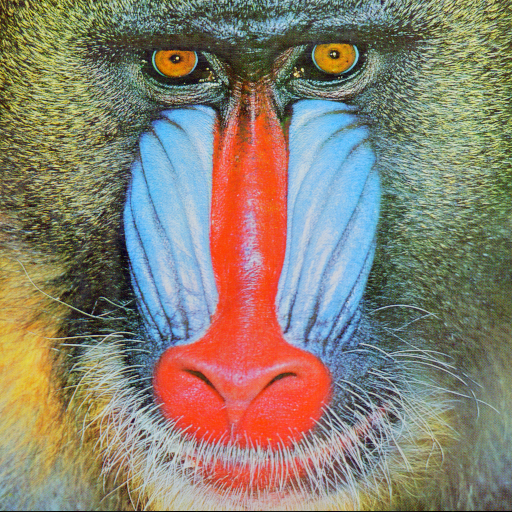

Y compressed


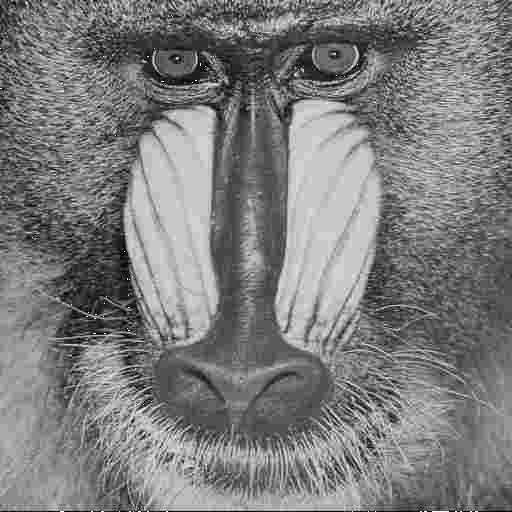

Cr compressed


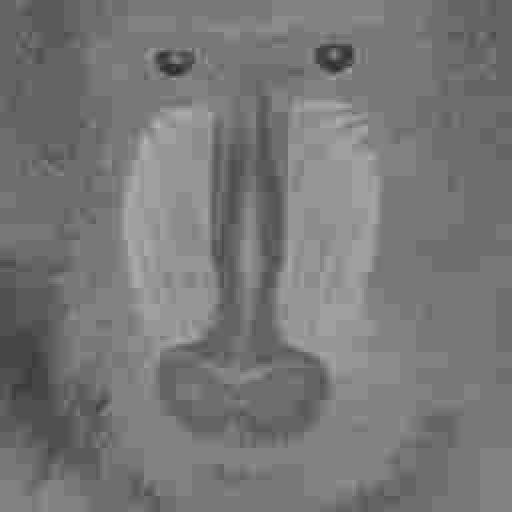

Cb compressed


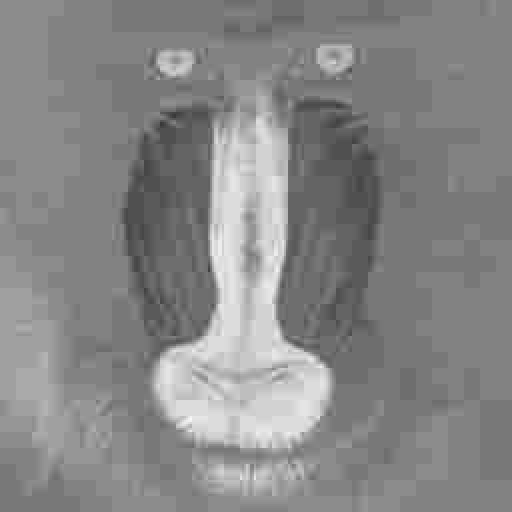

output


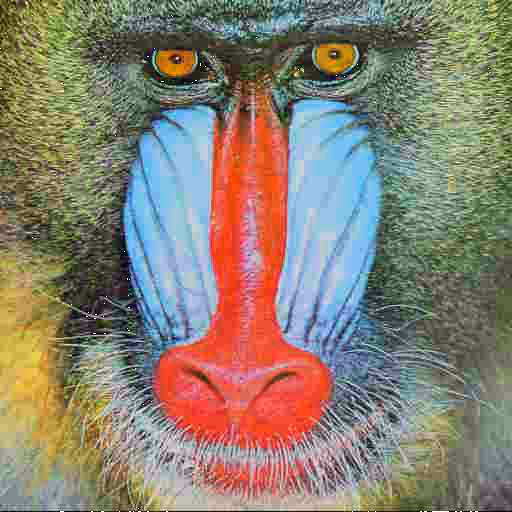

In [ ]:
jpg_compression()